In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
# Dummy data to test
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-02'),
    first_days=5,
    split='train',
    tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
# Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    first_days=2,
    tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(
    ds_train.compute_weights(), len(ds_train)
)

In [8]:
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=32, sampler=sampler_train
)

In [9]:
gen = Generator(
    nres=1, nf_in=1, nf=16, use_noise=True, activation_out='relu'
).to(device)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [11]:
trainer = Trainer(gen, optimizer, criterion, dl_train)

In [12]:
# trainer.fit(50)

In [13]:
# torch.save(gen.state_dict(), f'gen_pretrained.pt')
gen.load_state_dict(torch.load('gen_pretrained.pt'))

<All keys matched successfully>

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


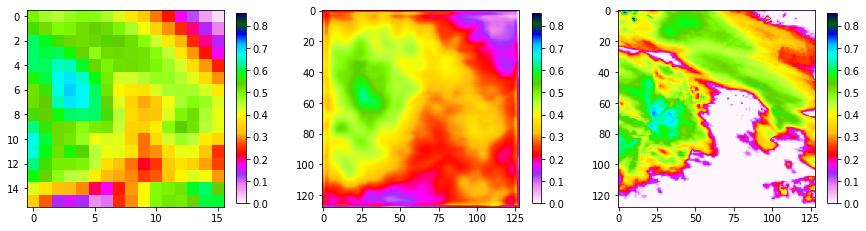

In [14]:
X, y = next(iter(dl_train))
plot_sample(X, y, gen, 0)

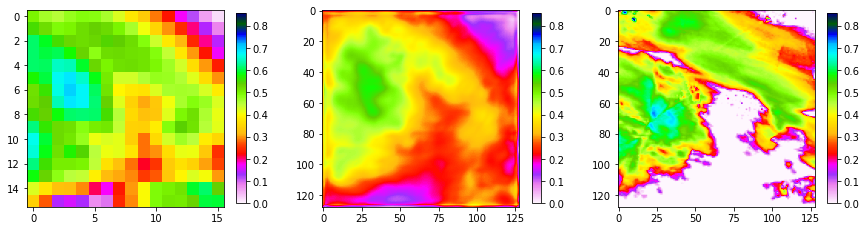

In [15]:
plot_sample(X, y, gen, 0)

## Evaluation

### Get predictions

In [16]:
# Note that we are using xarray datasets for handling our data!
# This makes things SO MUCH easier :)
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        pred = model(torch.FloatTensor(X[None]).to(device)).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Un-log
    if ds_valid.tp_log:
        preds = log_retrans(preds, ds_valid.tp_log)
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(
                lat=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[1])
            ),
            'lon': ds_valid.mrms.lon.isel(
                lon=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[2])
            )
        },
        name='tp'
    )
    return preds

In [17]:
def create_valid_ensemble(model, ds_valid, nens):
    """Wrapper to create ensemble"""
    preds = [create_valid_predictions(model, ds_valid) for _ in range(nens)]
    return xr.concat(preds, 'member')

In [18]:
det_pred = create_valid_predictions(gen, ds_test)

In [19]:
det_pred

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[ 3.94085884e-01,  3.39000493e-01,  2.70638853e-01, ...,
          3.12299639e-01,  3.54141295e-01,  9.68418792e-02],
        [ 5.28432190e-01,  4.01598662e-01,  3.30732912e-01, ...,
          2.36293644e-01,  1.79771811e-01,  3.35170850e-02],
        [ 5.63860714e-01,  4.56602007e-01,  3.43610704e-01, ...,
          2.83986151e-01,  2.18378603e-01,  4.86063585e-02],
        ...,
        [ 2.17287928e-01,  6.24952838e-02,  2.93591842e-02, ...,
          2.40385056e-01,  2.78984487e-01,  1.03016235e-01],
        [ 2.20217079e-01,  8.49443749e-02,  4.60772142e-02, ...,
          4.30187434e-01,  4.72042769e-01,  2.13702440e-01],
        [ 1.09394200e-01,  1.72949806e-02,  1.43875703e-02, ...,
          1.76141620e-01,  1.80915624e-01,  5.32001331e-02]],

       [[ 5.00773072e-01,  3.94250900e-01,  3.14532191e-01, ...,
          4.69069153e-01,  5.07284760e-01,  6.26407936e-02],
        [ 5.92468858e-01,  3.67002368e-01,  2.26315171e-01, ...,
          1.46111012e-01,  1.20989792e-01, -7.45058060e-09],
        [ 6.19852543e-01,  3.98286045e-01,  2.32264191e-01, ...,
          2.11994439e-01,  1.68376386e-01, -7.45058060e-09],
...
          1.56204402e-01,  2.00944096e-01,  7.36617818e-02],
        [ 4.12574440e-01,  1.25114739e-01,  6.59018680e-02, ...,
          3.71377826e-01,  4.18048054e-01,  1.95431143e-01],
        [ 1.85352892e-01,  1.33770481e-02,  1.45740807e-03, ...,
          1.60130560e-01,  1.68214351e-01,  4.67317030e-02]],

       [[ 4.53822821e-01,  3.79135013e-01,  3.19538057e-01, ...,
          3.20609689e-01,  3.44517797e-01,  6.43034652e-02],
        [ 5.35001099e-01,  3.27938735e-01,  1.73891217e-01, ...,
          1.02842025e-01,  9.23485681e-02, -7.45058060e-09],
        [ 5.60033441e-01,  3.29834729e-01,  1.68615043e-01, ...,
          1.42124027e-01,  1.17743753e-01, -7.45058060e-09],
        ...,
        [ 5.22906125e-01,  1.03611656e-01,  2.46923417e-02, ...,
          1.39998674e-01,  1.72422022e-01,  3.83972749e-02],
        [ 5.19398928e-01,  1.20831184e-01,  4.85982075e-02, ...,
          2.83176124e-01,  3.37879717e-01,  1.45009995e-01],
        [ 2.22669035e-01,  2.15362757e-03, -7.45058060e-09, ...,
          1.21500127e-01,  1.40834302e-01,  2.90499553e-02]]],
      dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [20]:
ens_pred = create_valid_ensemble(gen, ds_test, nens=10)

In [21]:
ens_pred

<xarray.DataArray 'tp' (member: 10, valid_time: 44, lat: 744, lon: 1376)>
array([[[[ 3.86644840e-01,  3.76043856e-01,  2.92450070e-01, ...,
           3.88895869e-01,  4.28744107e-01,  1.30627006e-01],
         [ 5.08374929e-01,  4.06431764e-01,  2.54068226e-01, ...,
           4.28957552e-01,  3.36724788e-01,  8.50457177e-02],
         [ 5.32432497e-01,  4.35318559e-01,  2.64835179e-01, ...,
           5.63678265e-01,  4.62695271e-01,  1.06453381e-01],
         ...,
         [ 4.30832535e-01,  1.01751111e-01,  3.25520262e-02, ...,
           1.81009889e-01,  2.29552925e-01,  9.37286243e-02],
         [ 4.38782722e-01,  1.26109958e-01,  5.89568391e-02, ...,
           3.63861084e-01,  4.47974890e-01,  2.54849017e-01],
         [ 2.09238380e-01,  1.24132112e-02, -7.45058060e-09, ...,
           1.79938614e-01,  2.14972317e-01,  7.70088509e-02]],

        [[ 4.44096953e-01,  3.49912137e-01,  2.76687205e-01, ...,
           3.69203180e-01,  3.98240089e-01,  7.34179541e-02],
         [ 5.35337389e-01,  3.46476525e-01,  2.48577535e-01, ...,
           1.35170460e-01,  1.18098699e-01, -7.45058060e-09],
         [ 5.60864568e-01,  3.82928163e-01,  2.57249951e-01, ...,
           1.80651814e-01,  1.53008074e-01, -7.45058060e-09],
...
           1.19817622e-01,  1.62081212e-01,  4.22478393e-02],
         [ 5.22947192e-01,  1.19879924e-01,  4.05805781e-02, ...,
           2.98259944e-01,  3.60660851e-01,  1.69313163e-01],
         [ 2.34908789e-01,  2.81829387e-03, -7.45058060e-09, ...,
           1.43504530e-01,  1.62468225e-01,  4.08146903e-02]],

        [[ 4.02903706e-01,  2.99599886e-01,  2.32651383e-01, ...,
           4.11928266e-01,  4.40652221e-01,  6.85510859e-02],
         [ 3.76626879e-01,  1.86265767e-01,  1.08205535e-01, ...,
           1.56779557e-01,  1.30411297e-01, -7.45058060e-09],
         [ 4.19314533e-01,  2.08114982e-01,  1.10684238e-01, ...,
           2.40601897e-01,  1.86777353e-01, -7.45058060e-09],
         ...,
         [ 6.02129400e-01,  1.20746024e-01,  1.99478269e-02, ...,
           1.87335491e-01,  2.26341575e-01,  7.35464916e-02],
         [ 6.01229966e-01,  1.37693107e-01,  4.54721376e-02, ...,
           3.80886137e-01,  4.36960787e-01,  2.05304921e-01],
         [ 2.64600456e-01,  4.70621139e-03, -7.45058060e-09, ...,
           1.65540755e-01,  1.82958990e-01,  5.12986109e-02]]]],
      dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
Dimensions without coordinates: member

### Compute scores

In [22]:
from src.evaluation import *

Need to mask out regions where there is no radar

In [23]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [24]:
eval_mask

<xarray.DataArray (lat: 750, lon: 1376)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] ...
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [40]:
mrms = ds_test.mrms.sel(lat=det_pred.lat, lon=det_pred.lon).rename(
    {'time': 'valid_time'}) * ds_test.maxs.tp.values
mrms = log_retrans(mrms, ds_test.tp_log)
mrms = mrms.where(eval_mask)

In [41]:
mrms

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[1.38777878e-17, 1.25000038e-02, 6.24999762e-03, ...,
         6.50000036e-01, 3.50000017e-01, 1.68750018e-01],
        [1.38777878e-17, 1.38777878e-17, 5.00000027e-02, ...,
         8.50000182e-01, 4.81250039e-01, 2.00000006e-01],
        [1.38777878e-17, 2.50000033e-02, 5.62500082e-02, ...,
         7.68750044e-01, 5.62500035e-01, 2.62499966e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         7.49999986e-01, 8.68750191e-01, 9.75000075e-01],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         4.56250065e-01, 5.87500060e-01, 7.06250069e-01],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         4.31250004e-01, 5.25000035e-01, 7.49999986e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] 2020-05-16

In [42]:
# Deterministic forecast RMSE
xs.rmse(det_pred, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.95344506)

In [43]:
# Emsemble mean forecast RMSE
xs.rmse(ens_pred.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.94586844)

In [44]:
# Ensemble CRPS
xs.crps_ensemble(mrms, ens_pred).values

array(0.35497819)

### Interpolation baseline

In [45]:
tigge = ds_test.tigge.isel(variable=0) * ds_test.maxs.tp.values
tigge = log_retrans(tigge, ds_test.tp_log)
tigge

<xarray.DataArray (valid_time: 44, lat: 93, lon: 172)>
array([[[5.60941382e-01, 1.64720819e+00, 3.38511103e+00, ...,
         9.19832432e-01, 8.54813406e-01, 8.42504299e-01],
        [6.02257318e-01, 2.78425370e-01, 6.16120139e-01, ...,
         8.11713823e-01, 8.54883523e-01, 9.64733087e-01],
        [4.28736388e+00, 2.67114920e+00, 7.84402507e-01, ...,
         7.31913405e-01, 7.93414214e-01, 8.92297932e-01],
        ...,
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         3.78249384e-04, 1.30273945e-03, 6.09075647e-04],
        [5.64457236e-03, 1.38777878e-17, 1.38777878e-17, ...,
         8.79674957e-02, 3.91880809e-02, 2.56075274e-01],
        [5.51259612e-03, 1.17728815e-04, 1.84873554e-04, ...,
         5.43296718e-01, 3.98564297e-01, 3.01565892e-01]],

       [[1.61871332e+00, 8.74794463e-01, 1.59606086e+00, ...,
         2.12971398e-01, 1.41367328e-01, 9.64246187e-02],
        [8.50851210e-02, 1.49924856e-02, 1.24233855e-01, ...,
         3.11670321e-01, 1.98064642e-01, 9.83297865e-02],
        [1.12202911e+00, 3.78966109e-01, 6.23947355e-02, ...,
         4.26584764e-01, 2.74970738e-01, 1.31330622e-01],
...
        [1.28996054e-04, 1.90191545e-03, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.50151570e-03, 1.38777878e-17, 9.09938706e-04, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [6.35852452e-03, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17]],

       [[1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         9.14610165e-01, 2.57977954e-01, 1.72763457e-01],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         4.31259440e-01, 5.08996204e-02, 3.98794935e-02],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         2.95156574e-01, 1.32262663e-02, 1.62853617e-02],
        ...,
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         4.77795204e-01, 1.98326807e-01, 7.70028383e-03],
        [1.38777878e-17, 1.38777878e-17, 4.66815522e-03, ...,
         4.77190766e-01, 1.71373896e-01, 9.71574012e-03],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         5.43066315e-01, 4.00218335e-01, 1.58019293e-01]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-02
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
    variable    <U2 'tp'

In [46]:
interp = tigge.interp_like(mrms, method='linear')

In [47]:
# Deterministic baseline RMSE
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.17905549)

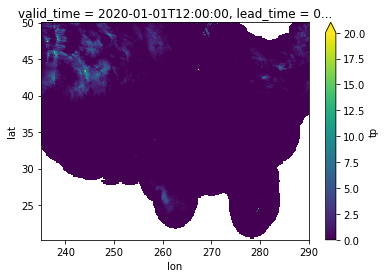

In [48]:
mrms.isel(valid_time=0).plot(vmin=0, vmax=20)

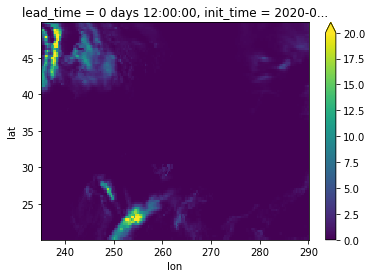

In [49]:
tigge.isel(valid_time=0).plot(vmin=0, vmax=20)

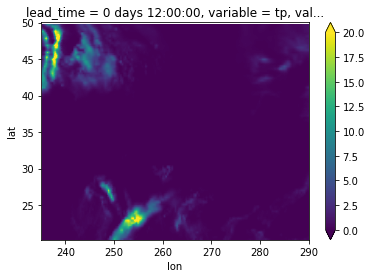

In [50]:
interp.isel(valid_time=0).plot(vmin=0, vmax=20)

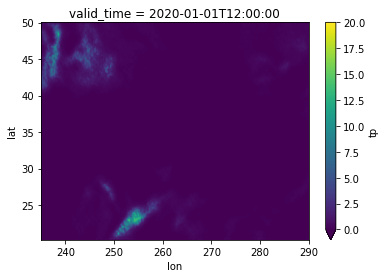

In [51]:
det_pred.isel(valid_time=0).plot(vmin=0, vmax=20)